In [6]:
import datetime
import pandas as pd
import numpy as np

data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['StartDate'] = pd.to_datetime(data['StartDate'])
data['EndDate'] = pd.to_datetime(data['EndDate'])

# Tickets:     clientes reais
# TicketsPrev: clientes estimados
# Persons:     número de pessoas em caixa (estimado)

from IPython.display import display, HTML

display(HTML('<center><h1>Predicting Tickets using Real Data and MLP</h1></center></br/>'))

display(HTML('<h1>Raw Data</h1></br/>'))

table = '<table>' \
            '<tr>' \
                '<td style="text-align: left">Tickets</td>' \
                '<td style="text-align: left">clientes reais</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">TicketsPrev</td>' \
                '<td style="text-align: left">clientes estimados pela Sisqual</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">Persons</td>' \
                '<td style="text-align: left">pessoas em caixa estimadas a partir de TicketsPrev</td>' \
            '</tr>' \
        '</table>'

display(HTML(table))

data

Tickets,clientes reais
TicketsPrev,clientes estimados pela Sisqual
Persons,pessoas em caixa estimadas a partir de TicketsPrev


,RosterCode,Date,StartDate,EndDate,Tickets,TicketsPrev,Persons
0,10,2021-11-01,2021-11-01 09:00:00,2021-11-01 10:00:00,32,55,2
1,10,2021-11-01,2021-11-01 10:00:00,2021-11-01 11:00:00,57,69,3
2,10,2021-11-01,2021-11-01 11:00:00,2021-11-01 12:00:00,87,112,4
3,10,2021-11-01,2021-11-01 12:00:00,2021-11-01 13:00:00,97,118,4
4,10,2021-11-01,2021-11-01 13:00:00,2021-11-01 14:00:00,100,130,4
...,...,...,...,...,...,...,...
204582,75,2022-10-31,2022-10-31 17:00:00,2022-10-31 18:00:00,52,38,2
204583,75,2022-10-31,2022-10-31 18:00:00,2022-10-31 19:00:00,122,66,3
204584,75,2022-10-31,2022-10-31 19:00:00,2022-10-31 20:00:00,125,92,3
204585,75,2022-10-31,2022-10-31 20:00:00,2022-10-31 21:00:00,114,70,3


In [7]:
data_filtered = data.drop(columns=['Date', 'EndDate' , 'Persons'])
display(HTML('<h1>Initial Data Filtered</h1>'))
data_filtered

,RosterCode,StartDate,Tickets,TicketsPrev
0,10,2021-11-01 09:00:00,32,55
1,10,2021-11-01 10:00:00,57,69
2,10,2021-11-01 11:00:00,87,112
3,10,2021-11-01 12:00:00,97,118
4,10,2021-11-01 13:00:00,100,130
...,...,...,...,...
204582,75,2022-10-31 17:00:00,52,38
204583,75,2022-10-31 18:00:00,122,66
204584,75,2022-10-31 19:00:00,125,92
204585,75,2022-10-31 20:00:00,114,70


In [8]:
display(HTML('<h1>Auxiliary Functions</h1>'))

def model_metrics(y_true, y_pred):
    d_metrics = {}
    d_metrics['mse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    d_metrics['mae'] = mean_absolute_error(y_true, y_pred)
    d_metrics['r2_score'] = r2_score(y_true, y_pred)
    
    return d_metrics

def streming_outlier_detection(ts, k, s, alpha):
    ts_copy = np.copy(ts)
    outliers = []

    prev_elements = np.ones(k)

    for i in range(k*s,len(ts)):
        for j in range(k):
            prev_elements[j]=ts[i-(j+1)*s]
            
        mu=np.mean(prev_elements)
        sigma=np.std(prev_elements)
        
        upper_whisker=mu+alpha*sigma
        lower_whisker=mu-alpha*sigma
        
        if ts[i]>upper_whisker or ts[i]<lower_whisker:
            outliers.append([i,ts[i]])
            masked=np.ma.masked_equal(prev_elements, 0)
            ts_copy[i]=np.where(masked.mean()==None, 0, masked.mean())
            
    return outliers, ts_copy

def to_supervised(timeseries, n_lags: int, n_output: int = 1):
    N = len(timeseries)

    n_rows = N - n_lags - n_output + 1
    
    X = np.zeros((n_rows, n_lags))
    y = np.zeros((n_rows, n_output))
    
    for i in range(N - n_lags):
        if i + n_lags + n_output > N:
            break

        aux = np.zeros(n_lags)

        for j in range(i, i + n_lags, 1):
            aux[j - i] = timeseries[j]

        X[i,:] = aux
        y[i,:] = timeseries[i + n_lags : i + n_lags + n_output]

    return X, y

def pre_process_data(data):
    data['ds'] = pd.to_datetime(data['ds'])
    data.shape

    data_resample = pd.DataFrame(data.resample('H', on = 'ds').sum())
    data_resample.reset_index(inplace=True)

    return data_resample


----------------------------------------------------------------------------------------------------------------
Store 10
----------------------------------------------------------------------------------------------------------------


{'mse': 15.48382096823572, 'mae': 7.769978312387227, 'r2_score': 0.937062063501574}


{'mse': 17.368394027978265, 'mae': 9.213888888888889, 'r2_score': 0.9208090516337591}


0.8432897776482973


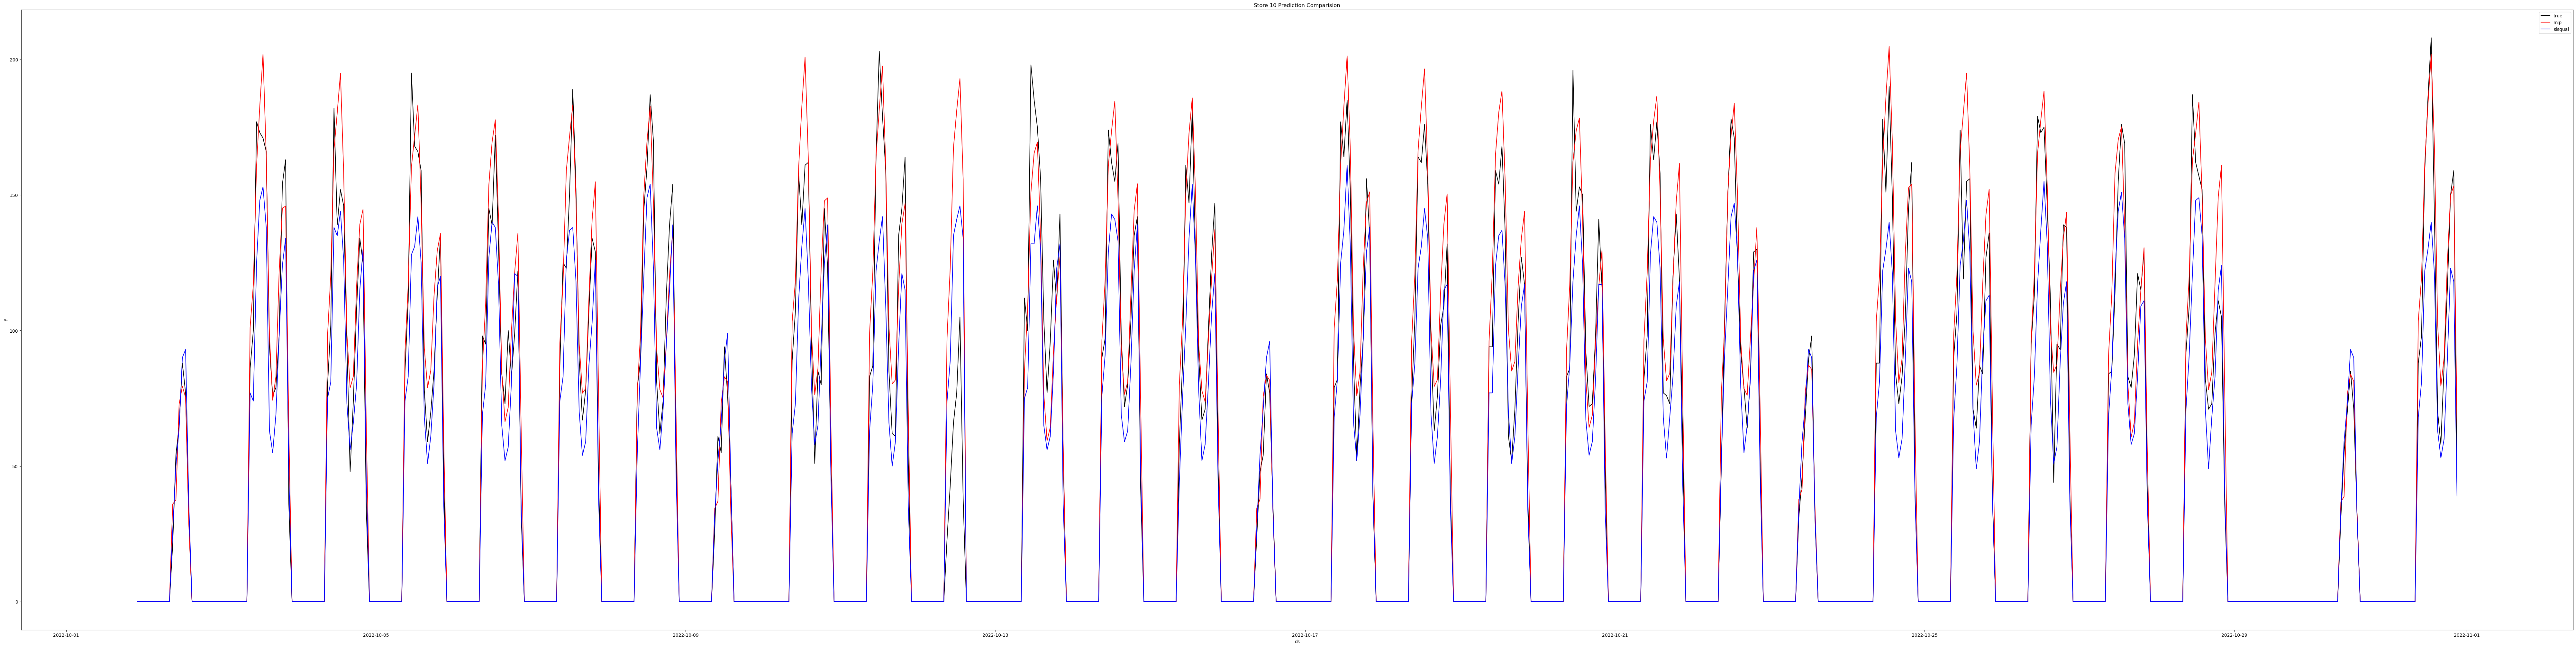

In [11]:
stores = pd.value_counts(data_filtered['RosterCode'].values.ravel())
stores_ids = list(stores.index)
stores_ids.sort()

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib import pyplot
from datetime import datetime, timedelta

DEBUG = False
SHOW_RAW = False

if DEBUG:
    display(HTML('<h3>Stores Ids</h3>'))
    print(stores_ids)
    print('')
    print('Nº stores: ' + str(len(stores_ids)))

d = {  'Store ID': []
     , 'Mlp MAE': []
     , 'Mlp MSE': []
     , 'Mlp R2': []
     , 'Sisq MAE': []
     , 'Sisq MSE': []
     , 'Sisq R2': []
     , 'RelMAE Mlp/Sisq': []}

stats = pd.DataFrame(data=d)

#j = 0
for id in stores_ids:
    store_data = data_filtered.loc[data_filtered['RosterCode'] == id]
    store_data = store_data.drop(columns=['RosterCode'])

    print('')
    print('----------------------------------------------------------------------------------------------------------------')
    print('Store ' + str(id))
    print('----------------------------------------------------------------------------------------------------------------')

    if DEBUG:
        display(HTML('<h3>Store Data</h3>'))
        print(store_data)
    
    #----------------------------------------------------------------------------------------------------------------

    store_data.rename(columns={"StartDate": "ds", "Tickets": "y", 'TicketsPrev': 'sisq'}, inplace=True)
    
    if DEBUG:
        display(HTML('<h3>Store Data Renamed</h3>'))
        print(store_data)
    
    #----------------------------------------------------------------------------------------------------------------
    
    store_data = pre_process_data(store_data)
    
    if DEBUG:
        display(HTML('<h3>Store Data Aggregated</h3>'))
        print(store_data)
    
    #----------------------------------------------------------------------------------------------------------------
    
    K = 53       # last k seasonal elements for comparison
    S = 168      # seasonality period
    ALPHA = 2    # standard deviation multiplication factor
    
    MAX_N_ITERATIONS = 1000
    
    n_lags = 720
    forecast_period = 720

    #----------------------------------------------------------------------------------------------------------------

    train_data = store_data[:-forecast_period].copy()
    test_data = store_data[-forecast_period:].copy()
    
    train_data.drop(columns=['sisq'], inplace=True)
    
    if DEBUG:
        display(HTML('<h3>Train Data</h3>'))
        print(train_data)
        display(HTML('<h3>Test Data</h3>'))
        print(test_data)
    
    #----------------------------------------------------------------------------------------------------------------

    outliers, filtered_values = streming_outlier_detection(train_data['y'].values, k=K, s=S, alpha=ALPHA)
    train_data['filtered_values'] = filtered_values
    
    if DEBUG:
        display(HTML('<h3>Outliers</h3>'))
        print(outliers)
        display(HTML('<h3>Filtered Values</h3>'))
        print(filtered_values)
        display(HTML('<h3>Train Data Filtered</h3>'))
        print(train_data)
    
    #----------------------------------------------------------------------------------------------------------------
    
    X, y = to_supervised(train_data['filtered_values'].values, n_lags=n_lags, n_output=forecast_period)
    
    if DEBUG:
        display(HTML('<h3>X</h3>'))
        print(X)
        print(X.shape)
        display(HTML('<h3>Y</h3>'))
        print(y)
        print(y.shape)
        
    #----------------------------------------------------------------------------------------------------------------
    
    # create model
    mlp_model = MLPRegressor(max_iter=MAX_N_ITERATIONS)

    # train model
    mlp_model.fit(X, y)

    #----------------------------------------------------------------------------------------------------------------

    y_last_known = np.asarray([train_data['y'][-forecast_period:].tolist()])
    
    if DEBUG:
        display(HTML('<h3>Prediction Input Data</h3>'))
        print(y_last_known)
        print(y_last_known.shape)

    y_last_known.reshape(1, -1)
    
    if DEBUG:
        display(HTML('<h3>Prediction Input Data Reshaped</h3>'))
        print(y_last_known)
        print(y_last_known.shape)
    
    forecast = mlp_model.predict(y_last_known)
    
    #----------------------------------------------------------------------------------------------------------------
    
    forecast = forecast.flatten().tolist()
    
    if DEBUG:
        display(HTML('<h3>Raw Forecast</h3>'))
        print(forecast)
    
    forecast = [0 if x < 0 else x for x in forecast]
    
    if DEBUG:
        display(HTML('<h3>Non-Negative Forecast</h3>'))
        print(forecast)
    
    #----------------------------------------------------------------------------------------------------------------
    
    x = test_data['ds']
    d = train_data['ds'][-1:].copy()
    d = d.tolist()[0]
    
    format = "%Y-%m-%d %H:%M:%S"
    ini_datetime = datetime.strptime(str(d), format)
    ds = []

    i = 1
    while i <= forecast_period:
        ds += [str(ini_datetime + timedelta(hours = i))]
        i += 1    

    if DEBUG:
        display(HTML('<h3>Initial Datatime</h3>'))
        print(ini_datetime)
        display(HTML('<h3>Test DS</h3>'))
        print(x)
        display(HTML('<h3>DS From Initial Datatime</h3>'))
        print(ds)
    
    #----------------------------------------------------------------------------------------------------------------
    
    if SHOW_RAW:
        mlp_metrics = model_metrics(test_data['y'], forecast)
        sisq_metrics = model_metrics(test_data['y'], test_data['sisq'])
    
        display(HTML('<h3>RAW</h3>'))
        display(HTML('<h3>MLP</h3>'))
        print(mlp_metrics)
        display(HTML('<h3>Sisqual</h3>'))
        print(sisq_metrics)
        #print('')
        display(HTML('<h3>MLP MAE / SIS MAE</h3>'))
        print(mlp_metrics['mae'] / sisq_metrics['mae'])
    
    forecast_with_zeros = []
    
    ind = 0
    
    for row in test_data.itertuples():
        if row.y > 0:
            forecast_with_zeros += [forecast[ind]]
        else:
            forecast_with_zeros += [0]
            
        ind += 1

    if DEBUG:
        display(HTML('<h3>Pred. Y Values</h3>'))
        print(forecast)
        display(HTML('<h3>Pred. Y with No-Zero Values</h3>'))
        print(forecast_with_zeros)
        
    mlp_metrics = model_metrics(test_data['y'], forecast_with_zeros)
    sisq_metrics = model_metrics(test_data['y'], test_data['sisq'])
    
    rel_mae = mlp_metrics['mae'] / sisq_metrics['mae']
    
    display(HTML('<h3>MLP</h3>'))
    print(mlp_metrics)
    display(HTML('<h3>Sisqual</h3>'))
    print(sisq_metrics)
    display(HTML('<h3>MAE: MLP/SIS</h3>'))
    print(rel_mae)
        
    stats = pd.concat([stats, pd.DataFrame([[  
                                       id
                                     , mlp_metrics['mae']
                                     , mlp_metrics['mse']
                                     , mlp_metrics['r2_score']
                                     , sisq_metrics['mae']
                                     , sisq_metrics['mse']
                                     , sisq_metrics['r2_score']                                     
                                     , rel_mae
                                    ]]
                                   , columns=stats.columns)]
                                   , ignore_index=True)    
        
    #----------------------------------------------------------------------------------------------------------------
    
    if SHOW_RAW:
        fig, ax = pyplot.subplots(figsize=(80, 20), layout='constrained')
        ax.plot(x, test_data['y'], label='true', color='black')
        ax.plot(x, forecast, label='mlp', color='red')
        ax.plot(x, test_data['sisq'], label='sisqual', color='blue')
    
        ax.set_xlabel('ds')
        ax.set_ylabel('y')
        ax.set_title('Store ' + str(id) + " Raw Prediction Comparision")
        ax.legend()
        fig.savefig('images/store_' + str(id) + '_raw_pred_acc_comp.png')
    
    #----------------------------------------------------------------------------------------------------------------    

    fig, ax = pyplot.subplots(figsize=(80, 20), layout='constrained')
    ax.plot(x, test_data['y'], label='true', color='black')
    ax.plot(x, forecast_with_zeros, label='mlp', color='red')
    ax.plot(x, test_data['sisq'], label='sisqual', color='blue')
    
    ax.set_xlabel('ds')
    ax.set_ylabel('y')
    ax.set_title('Store ' + str(id) + " Prediction Comparision")
    ax.legend()
    fig.savefig('images/store_' + str(id) + '_pred_acc_comp_considering_zeros.png')
    
    #j += 1
    
    #----------------------------------------------------------------------------------------------------------------        
    
    #if j > 6:
    #    break
    
    #break
 
filename = 'results/mlp_versus_sisq_pred_tickets_results.csv'
stats.to_csv(filename, index=False)